This notebook shows the development of functions used to visualize the circulation during upwelling events.

In [1]:
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
from matplotlib.dates import DateFormatter
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot
import functions_profiles

from salishsea_tools import nc_tools, viz_tools
from salishsea_tools import gsw_calls

In [2]:
bathy_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_05.nc')
bathy = bathy_file['Bathymetry']

coord_lats = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/coordinates/NEMO_files/coords_02.nc')['nav_lat'][:]

path = '/ocean/imachuca/Canyons/results_mackenzie/idealized/upwelling_events/'; cfg = 'eventB_1'
grid, lon, lat, tem, sal, ssh, U, V, W, tmask = functions_plot.load_model_output(path, cfg)
utau, vtau = functions_plot.load_model_other(path, cfg)
depth_levels = grid['deptht'][:]

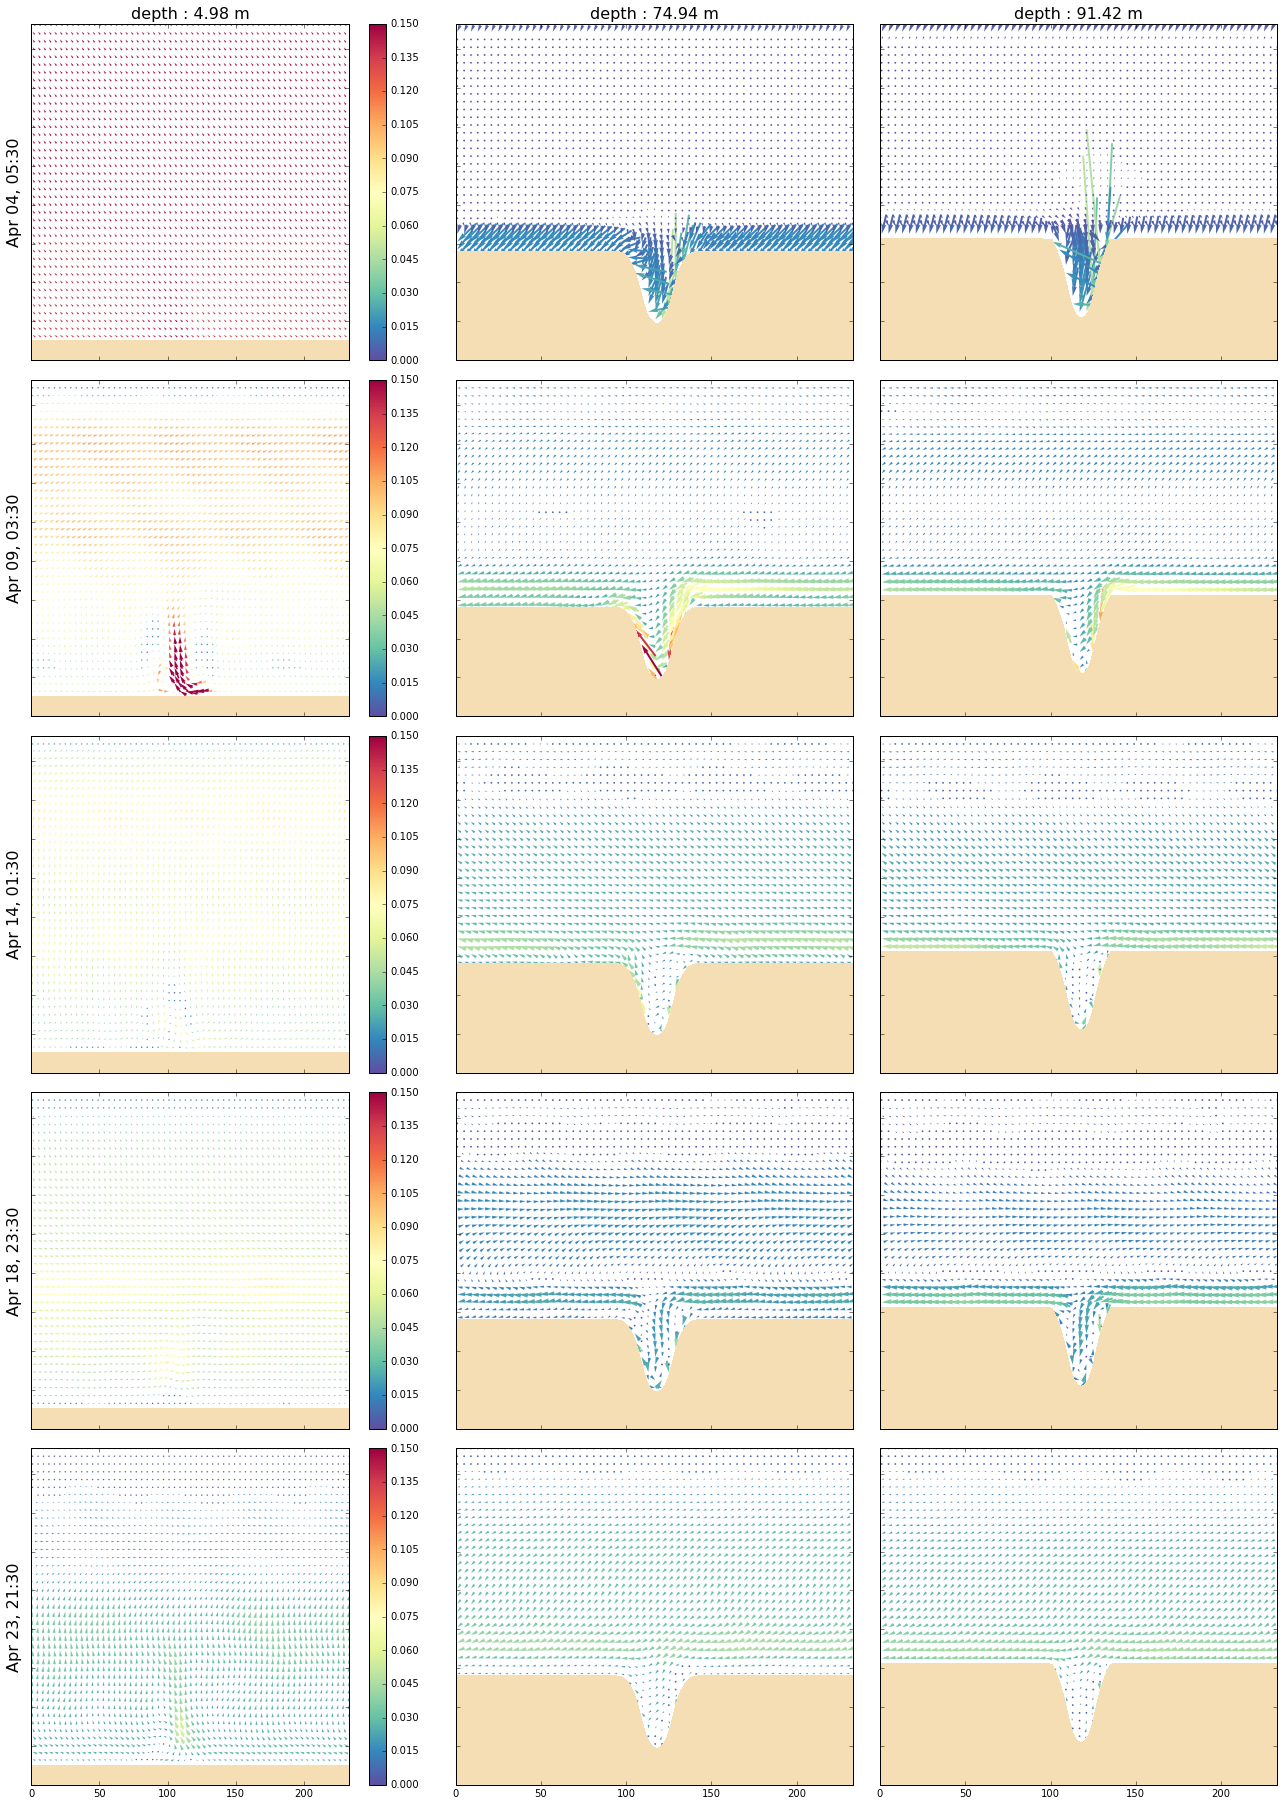

In [3]:
depth_inds = [0, 6, 7]
time_inds = np.linspace(5, 477, 5)
fig = functions_profiles.plot_quiver_stories(U, V, grid, depth_inds, time_inds, 0.15, 4, bathy_file)

In [4]:
def plot_incoming_speeds(U_vel, V_vel, gridT, depth_ind, time_inds, time_shot, max_vel, bathy_file, utau):
    
    # definitions
    x_point = 160; y_min = 55; y_max = 80; fs = 14.5
    dep_m = round(gridT['deptht'][:][depth_ind],2)

    fig = plt.figure(figsize=(20,12))
    ax1 = fig.add_subplot(2,2,1)
    ax2 = fig.add_subplot(2,2,2)
    ax3 = fig.add_subplot(2,1,2)
    fig.tight_layout()
    
    # find the speed at a depth and time to create pcolor
    x_slice, y_slice, u_nstg, v_nstg, speeds = functions_profiles.get_speeds(U_vel, V_vel, depth_ind, time_shot, 1)
    p = ax1.pcolor(speeds, vmin=0, vmax=max_vel, cmap='Spectral_r')
    viz_tools.plot_land_mask(ax1, bathy_file,'grid', dep_m, None, None, 'wheat')
    timestamp = nc_tools.timestamp(gridT, time_shot).format('MMM DD, HH:mm')
    ax1.set_title('Domain flow speeds on ' + timestamp + ' (' + str(dep_m) + ' m)', fontsize = fs)
    fig.colorbar(p, ax=ax1); ax1.tick_params(labelsize=fs)
    ax1.set_ylabel('y index', fontsize = fs); ax1.set_xlabel('x index', fontsize = fs)
    
    # define and plot the transect
    y_line = np.arange(y_min,y_max)
    x_line = np.ones_like(y_line)*x_point
    ax1.plot(x_line, y_line, linewidth=5, c='k', label='transect'); ax1.legend(loc=1)
    
    # convert all time indices into datetimes and convert these into matplotlib version
    dates = []
    utau_new = np.zeros(len(time_inds))
    for i in np.arange(len(time_inds)):
        dates.append(nc_tools.get_datetimes(grid)[time_inds[i]])
        utau_new[i] = utau[time_inds[i],-1,-1]
    dates = matplotlib.dates.date2num(dates)
    
    date_shot0 = nc_tools.get_datetimes(grid)[time_shot]
    date_shot = matplotlib.dates.date2num(date_shot0)
    
    # plot the wind stress
    ax2.plot_date(dates, utau_new, c='k', lw=3, markersize=8)
    ax2.axvline(date_shot, c = 'dodgerblue', lw=3, label='')
    ax2.xaxis.set_major_formatter(DateFormatter('%m-%d'))
    ax2.legend(loc=1); ax2.set_ylim([0.02, -0.16]); ax2.tick_params(labelsize=fs)
    ax2.set_title('Wind stress profile', fontsize = fs)
    ax2.set_xlabel('dates', fontsize = fs); ax2.set_ylabel('wind stress [Nm$^{-2}$]', fontsize = fs)

    # crop the velocities for the transect
    U_vel = U_vel[:, :, y_min:y_max, x_point-1:x_point+1]
    V_vel = V_vel[:, :, y_min:y_max, x_point-1:x_point+1]
    
    # get the speeds along the transect at every time index and then store in a matrix
    len_y = len(y_line)-1
    speeds_all = np.zeros([len_y,len(time_inds)])
    for time_ind, m in zip(time_inds, np.arange(len(time_inds))):
        x_slice, y_slice, u_nstg, v_nstg, speeds = functions_profiles.get_speeds(U_vel, V_vel, depth_ind, time_ind, 1)
        for n in zip(np.arange(len_y)):
            speeds_all[n, m] = speeds[n, :]
    
    # define colors for every point along the transect
    cms = np.linspace(0, 1, len_y)
    cs = [ cm.jet(x) for x in cms]
    
    # plot speeds at every point and use plot_date to use matplotlib's datetime 
    for n in np.arange(len_y):
        ax3.plot_date(dates, speeds_all[n, :], color = cs[n], linestyle='-', label = str(y_line[n]))
    ax3.axvline(date_shot, c = 'dodgerblue', lw=3, label='')    
    ax3.xaxis.set_major_formatter(DateFormatter('%m-%d'))
    ax3.legend(ncol=12, loc=1); ax3.tick_params(labelsize=fs)
    ax3.set_xlabel('dates', fontsize = fs); ax3.set_ylabel('flow speed [ms$^{-1}$]', fontsize = fs)
    ax3.set_title('Speed of the incoming flow different points along the transect', fontsize = fs)
    fig.subplots_adjust(hspace=.2, wspace=.2)
    
    plt.show()
    return fig

# 91 m depth (plotted every 25 hours)

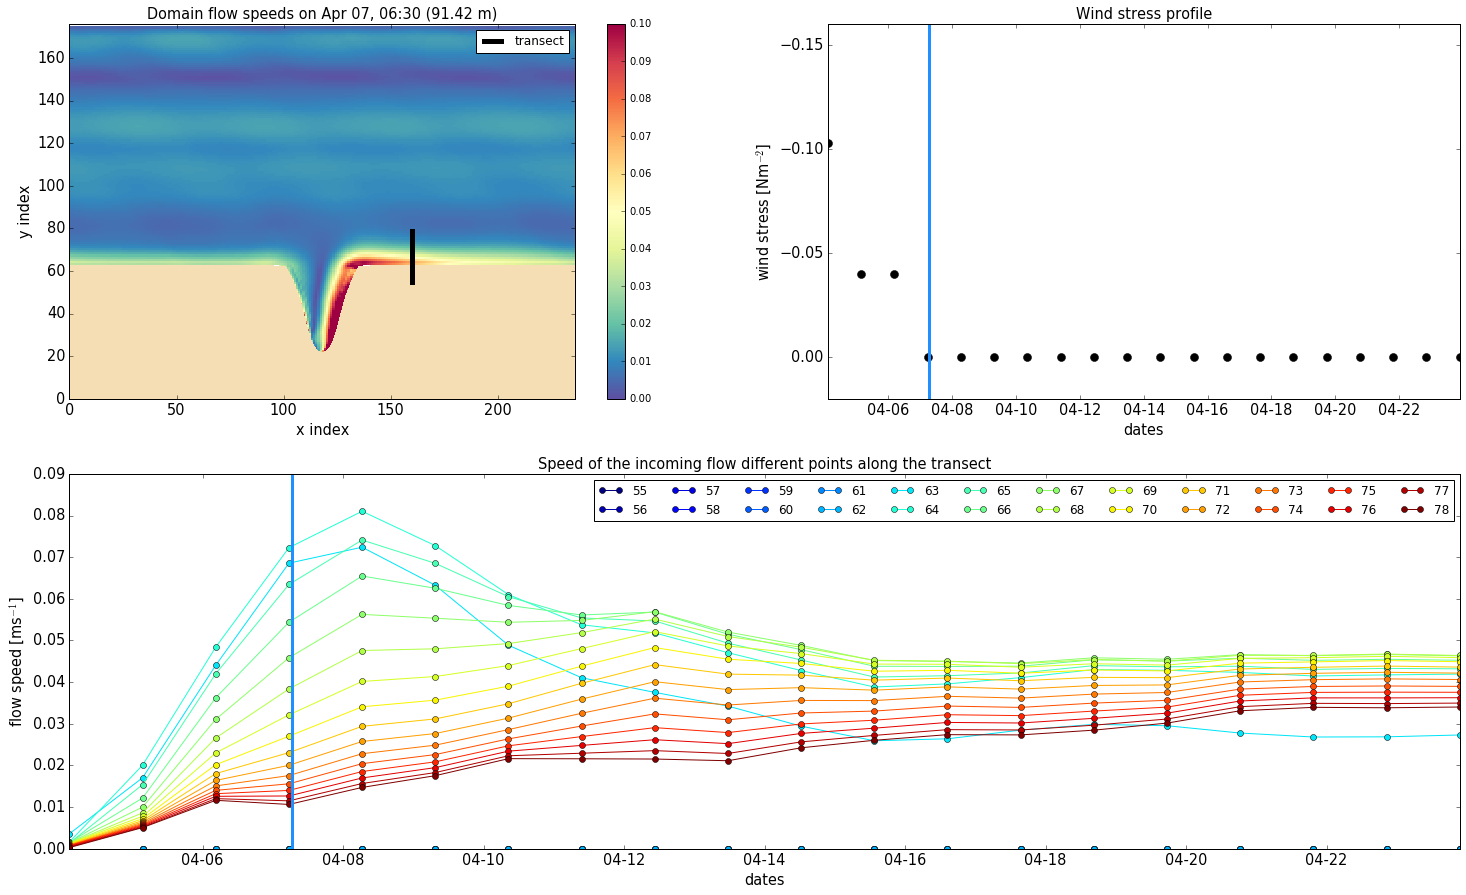

In [5]:
time_shot=3.25*24
time_inds = np.arange(2,479,25)
fig = plot_incoming_speeds(U, V, grid, 7, time_inds, time_shot, 0.1, bathy_file, utau)

# 91 m depth (plotted every 14 hours)

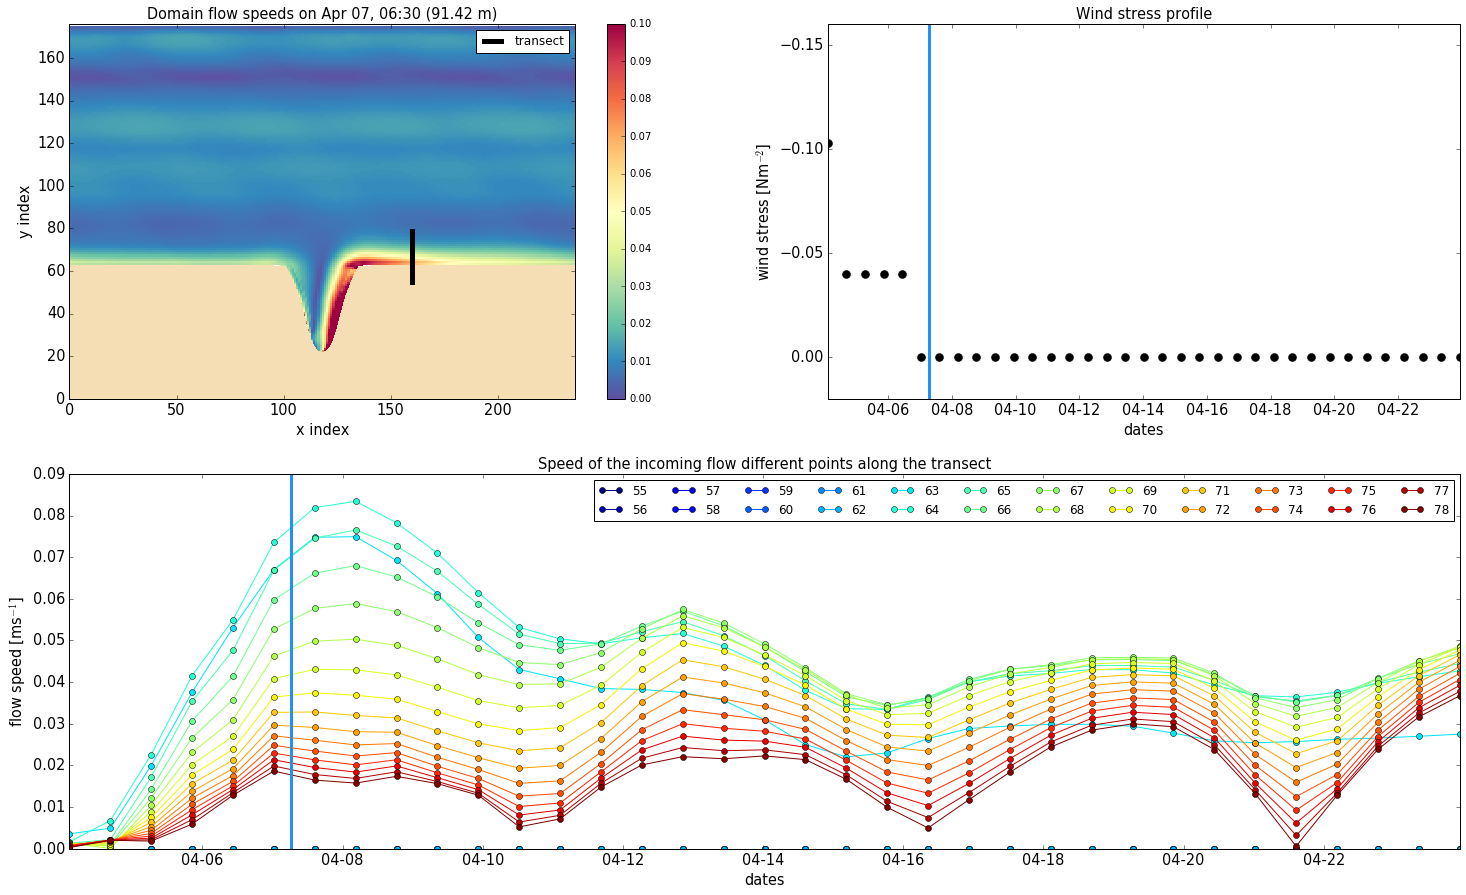

In [6]:
time_shot=3.25*24
time_inds = np.arange(2,479,14)
fig = plot_incoming_speeds(U, V, grid, 7, time_inds, time_shot, 0.1, bathy_file, utau)

# 91 m depth (plotted every 3 hours)

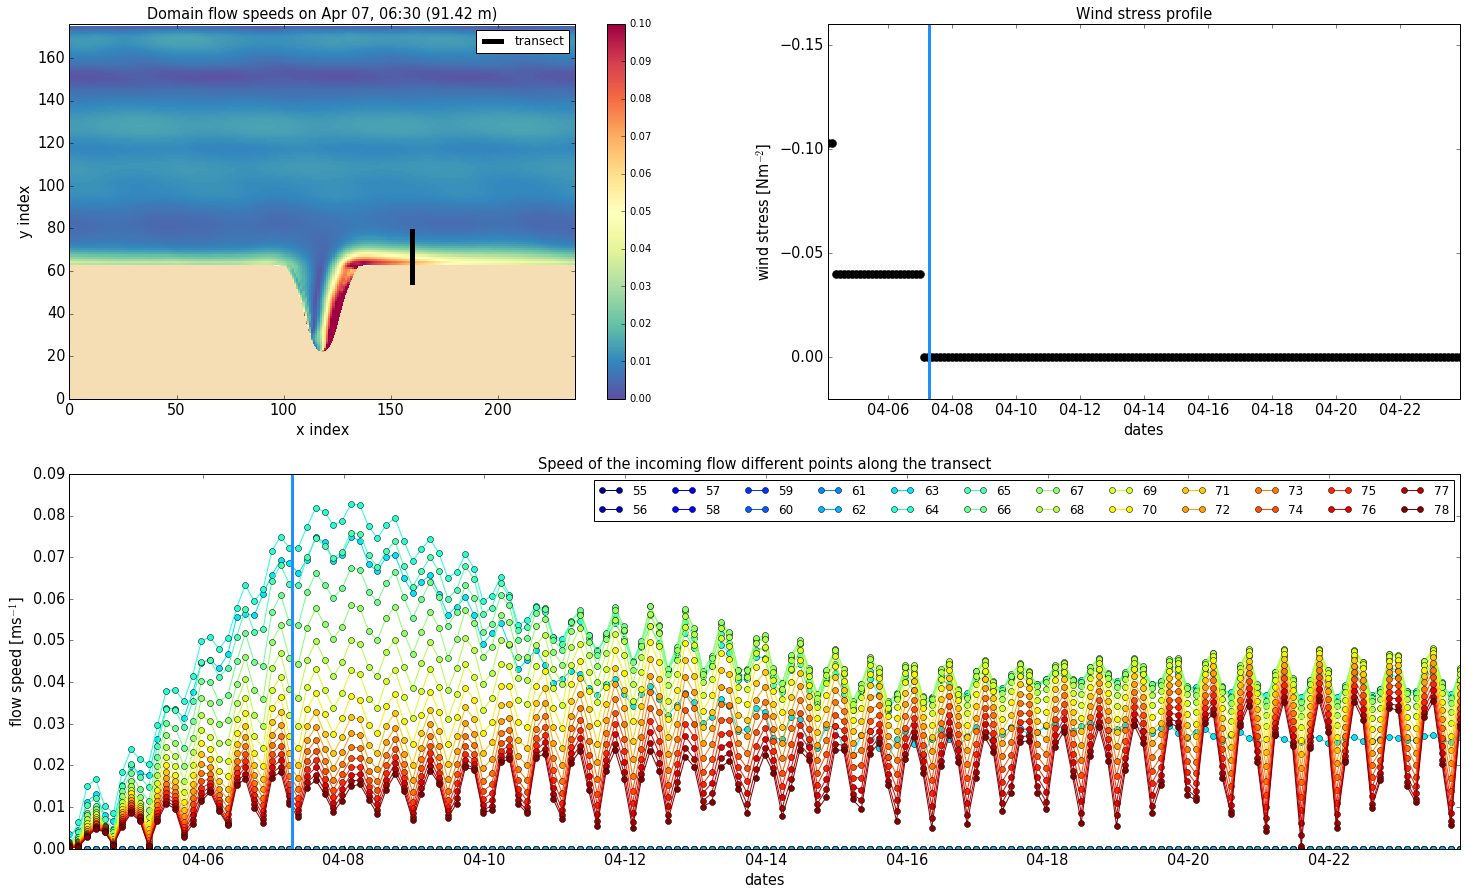

In [7]:
time_shot=3.25*24
time_inds = np.arange(2,479,3)
fig = plot_incoming_speeds(U, V, grid, 7, time_inds, time_shot, 0.1, bathy_file, utau)

# 74 m depth (plotted every 25 hours)

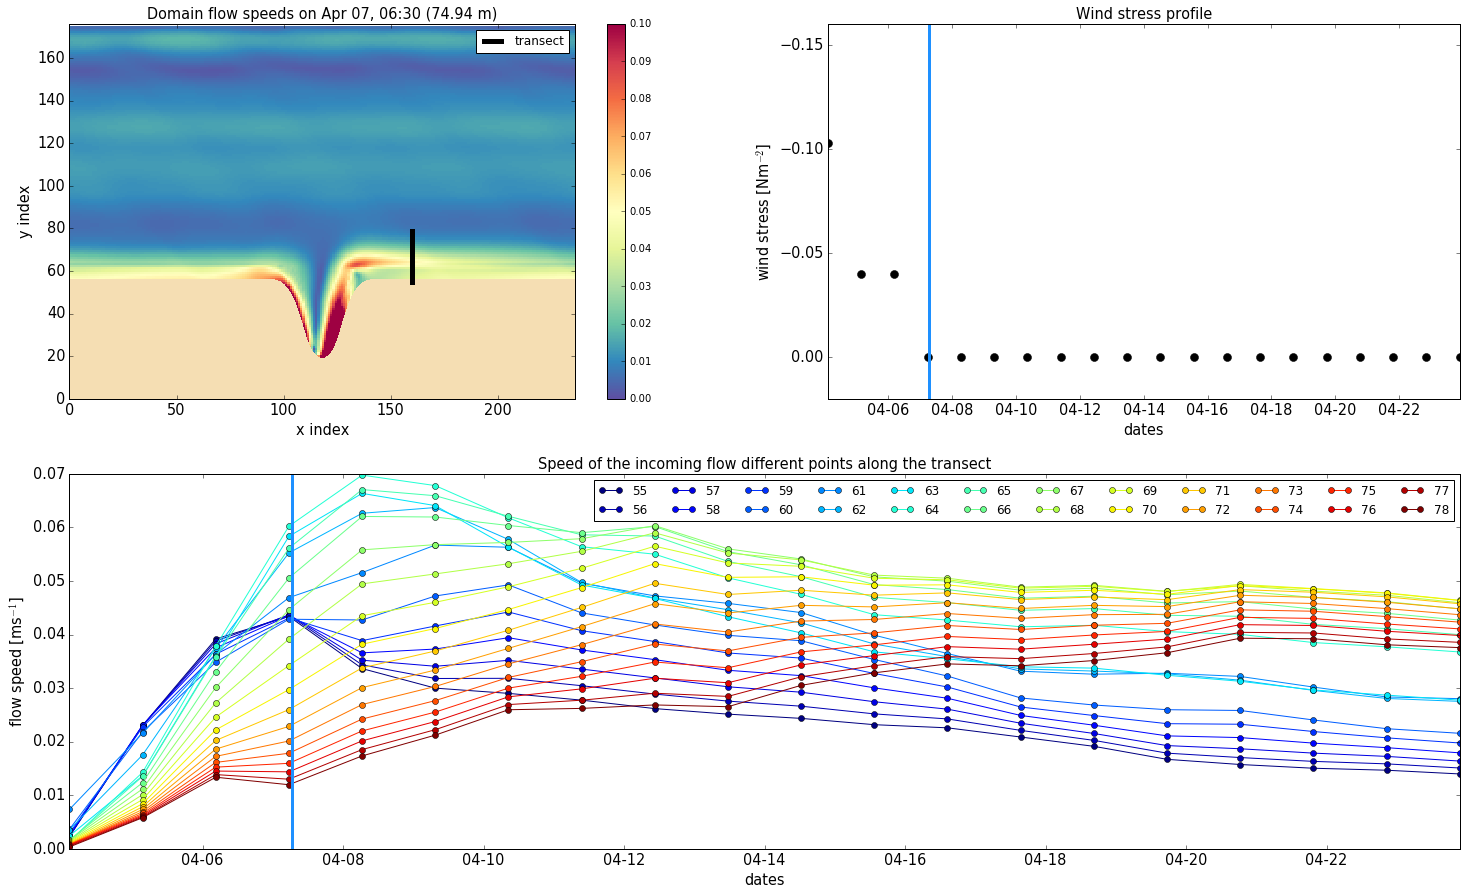

In [8]:
time_shot=3.25*24
time_inds = np.arange(2,479,25)
fig = plot_incoming_speeds(U, V, grid, 6, time_inds, time_shot, 0.1, bathy_file, utau)

# 111 m depth (plotted every 25 hours)

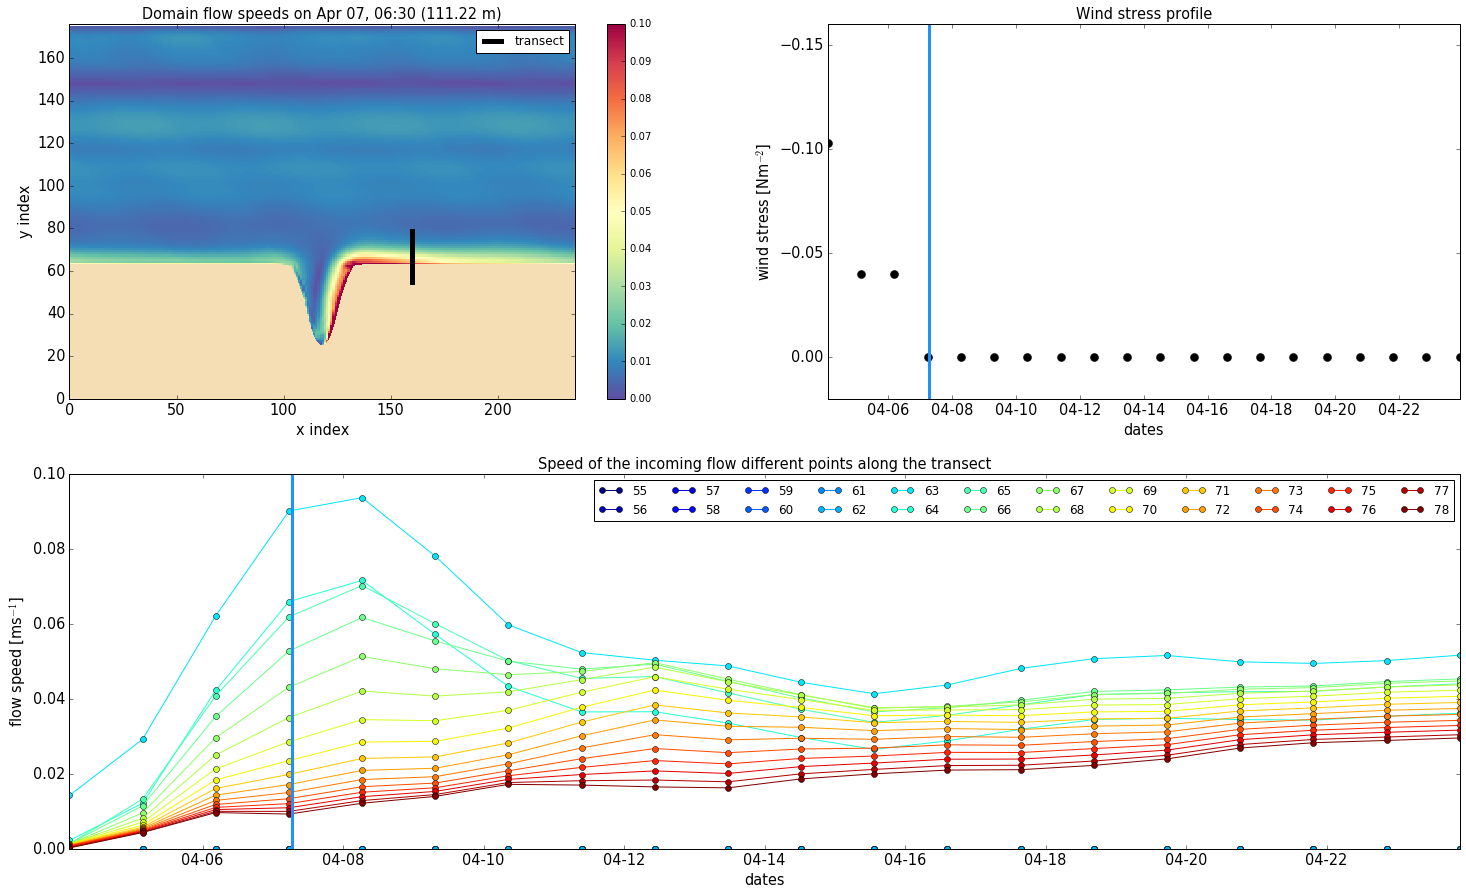

In [9]:
time_shot=3.25*24
time_inds = np.arange(2,479,25)
fig = plot_incoming_speeds(U, V, grid, 8, time_inds, time_shot, 0.1, bathy_file, utau)

In [3]:
ts_data_deep = sio.loadmat('../data/for_stratification/canyonTSdata2.mat')
i_ref = 0
sal_ref = ts_data_deep['salcanyon2'][:, i_ref]
dep_ref = ts_data_deep['depthcanyon2'][:, i_ref]*-1

In [41]:
def get_inds_max_depth(time_shot): 
    inds_max_depth = np.zeros([sal.shape[2],sal.shape[3]])
    for j in range(sal.shape[2]):
        for i in range(sal.shape[3]):
            sal_column = sal[time_shot, :, j, i]
            try:
                ind = np.where(sal_column == np.nanmax(sal_column))[0][0]
            except IndexError:
                ind = 0
            inds_max_depth[j, i] = ind
    return inds_max_depth

def get_unique_values(inds_max_depth):
    depth_ind_rim = 7
    x_ind_rim_depth = np.where(inds_max_depth == depth_ind_rim)[1]
    y_ind_rim_depth = np.where(inds_max_depth == depth_ind_rim)[0]

    unique_x_values = np.unique(x_ind_rim_depth)
    ys_for_unique_x_values = np.zeros_like(unique_x_values)
    for n in range(len(ys_for_unique_x_values)):
        same_x_value = unique_x_values[n]
        inds_same_x_value = [i for i, x in enumerate(x_ind_rim_depth) if x == same_x_value]
        ys_for_same_x_value = (y_ind_rim_depth[inds_same_x_value])
        max_y_value = ys_for_same_x_value.min()
        ys_for_unique_x_values[n] = max_y_value
    return ys_for_unique_x_values, unique_x_values, x_ind_rim_depth, y_ind_rim_depth

def get_rim_values(inds_max_depth):
    rim_y_xleft_xright = np.zeros([sal.shape[2],3])
    for y_ind in range(sal.shape[2]):
        ref_ind_max = inds_max_depth[y_ind,0]
        try:
            x_ind_below_rim = np.where(inds_max_depth[y_ind, :] != ref_ind_max)[0]
            x_ind_rim_left = x_ind_below_rim[0]
            x_ind_rim_right = x_ind_below_rim[-1]
        except IndexError:
            x_ind_rim_left = np.nan
            x_ind_rim_right = np.nan
        rim_y_xleft_xright[y_ind, 0] = y_ind
        rim_y_xleft_xright[y_ind, 1] = x_ind_rim_left
        rim_y_xleft_xright[y_ind, 2] = x_ind_rim_right
    return rim_y_xleft_xright

def get_sal_profiles_rim(y_inds, x_inds):
    sal_profiles_rim = ma.masked_all([30, len(x_inds)])
    for y, x, n in zip(y_inds, x_inds, np.arange(len(x_inds))):
        try:    
            this_profile = sal[time_shot, :, y, x]
            sal_profiles_rim[:, n] = this_profile
        except IndexError:
            sal_profiles_rim[:, n] = np.nan
    return sal_profiles_rim

In [10]:
def calculate_depth_change(sal_profiles_rim, ind_dep_above_rim):
    depth_change = np.zeros(sal_profiles_rim.shape[1])
    for unique_point in range(len(depth_change)):
        sal_result = sal_profiles_rim[ind_dep_above_rim, unique_point]
        ind_result_nearest_ref = min(range(len(sal_ref)), key=lambda i: abs(sal_ref[i]-sal_result))
        d_ref = dep_ref[ind_result_nearest_ref]
        d_new = grid['deptht'][ind_dep_above_rim]
        depth_change[unique_point] = d_ref - d_new
    return depth_change, d_new

def plot_depth_change(fig, axA, axB, depth_change, d_new):
    vmax, vmin = 40, -40; fs = 14.5
    axA.plot(depth_change, c = 'gray', lw=2)
    axA.scatter(np.arange(len(depth_change)), depth_change, c=depth_change, cmap = cmo.cm.curl, 
                vmin=vmin, vmax=vmax, s=100)
    axA.text(43, 50, 'up', fontsize = fs, bbox={'facecolor':'white', 'pad':6})
    axA.text(43, -10, 'down', fontsize = fs, bbox={'facecolor':'white', 'pad':6})
    axA.axhline(0, c='k', lw=2); axA.yaxis.grid(); axA.set_ylim([-30, 40]); axA.tick_params(labelsize=fs)
    axA.set_title('Depth change at points along rim [' + str(round(d_new,1))+ 'm]', fontsize = fs)
    axA.set_xlabel('indices of points', fontsize = fs); axA.set_ylabel('difference [m]', fontsize = fs)

    s = axB.scatter(unique_x_values, ys_for_unique_x_values, c=depth_change, cmap = cmo.cm.curl, 
                    vmin=vmin, vmax=vmax, s=120)
    fig.colorbar(s, ax=axB); axB.tick_params(labelsize=fs)
    axB.set_title('Depth change at points along rim [' + str(round(d_new,1))+ 'm]', fontsize = fs)
    axB.set_xlabel('x index', fontsize = fs); axB.set_ylabel('y index', fontsize = fs)
    return axA, axB

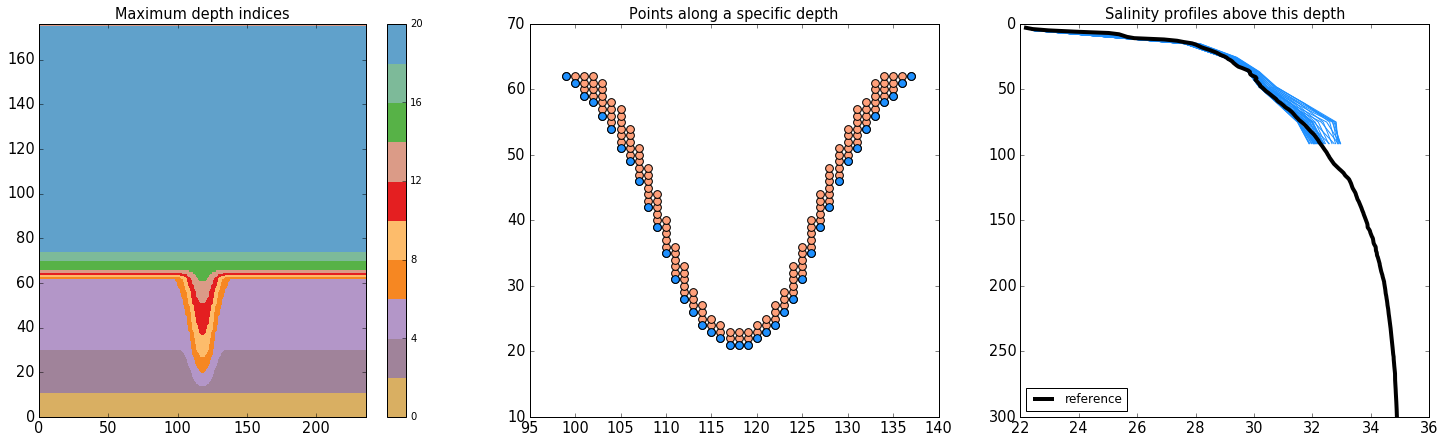

In [199]:
time_shot=3.25*24
inds_max_depth = get_inds_max_depth(time_shot)
ys_for_unique_x_values, unique_x_values, x_ind_rim_depth, y_ind_rim_depth = get_unique_values(inds_max_depth)
sal_profiles_dep = get_sal_profiles_rim(ys_for_unique_x_values, unique_x_values)

#------------------------------------------------------------------------------
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,6))
fig.tight_layout(); fig.subplots_adjust(hspace=.3, wspace=.2); fs=14.5
p1 = ax1.contourf(inds_max_depth, cmap = 'Paired_r', levels=np.arange(22)[::2])
fig.colorbar(p1, ax=ax1); ax1.set_title('Maximum depth indices', fontsize = fs); ax1.tick_params(labelsize=fs)

ax2.scatter(x_ind_rim_depth, y_ind_rim_depth, s = 60, c = 'lightsalmon')
ax2.scatter(unique_x_values, ys_for_unique_x_values, s = 60, c='dodgerblue')
ax2.set_title('Points along a specific depth', fontsize = fs); ax2.tick_params(labelsize=fs)

ax3.plot(sal_profiles_dep, grid['deptht'], c='dodgerblue', label='')
ax3.plot(sal_ref, dep_ref, lw = 2, c='k', linewidth=4, label = 'reference')
ax3.set_ylim([300,0]); ax3.legend(loc=3)
ax3.set_title('Salinity profiles above this depth', fontsize = fs); ax3.tick_params(labelsize=fs)

In [42]:
time_shot=3.25*24
inds_max_depth = get_inds_max_depth(time_shot)
rim_y_xleft_xright = get_rim_values(inds_max_depth)
sal_profiles_rim_left = get_sal_profiles_rim(rim_y_xleft_xright[:,1], rim_y_xleft_xright[:,0])
sal_profiles_rim_right = get_sal_profiles_rim(rim_y_xleft_xright[:,2], rim_y_xleft_xright[:,0])

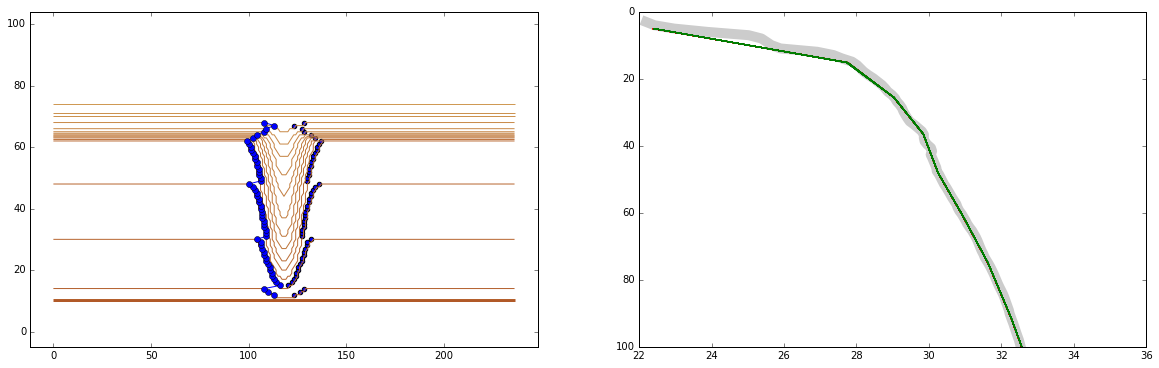

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,6))
p1 = ax1.contour(inds_max_depth[0:100,:], cmap = 'Paired_r', levels=np.arange(500))
ax1.plot(rim_y_xleft_xright[:,1], rim_y_xleft_xright[:,0], marker='o')
ax1.scatter(rim_y_xleft_xright[:,2], rim_y_xleft_xright[:,0], marker='o')

ax2.plot(sal_ref, dep_ref, lw = 2, c='k', linewidth=10, label = 'reference', alpha=0.2)
ax2.plot(sal_profiles_rim_left, grid['deptht'], c='r')
ax2.plot(sal_profiles_rim_right, grid['deptht'], c='g')
#ax2.invert_yaxis()
ax2.set_ylim([100,0])

plt.show()

# Upwelling depth

<function matplotlib.pyplot.show>

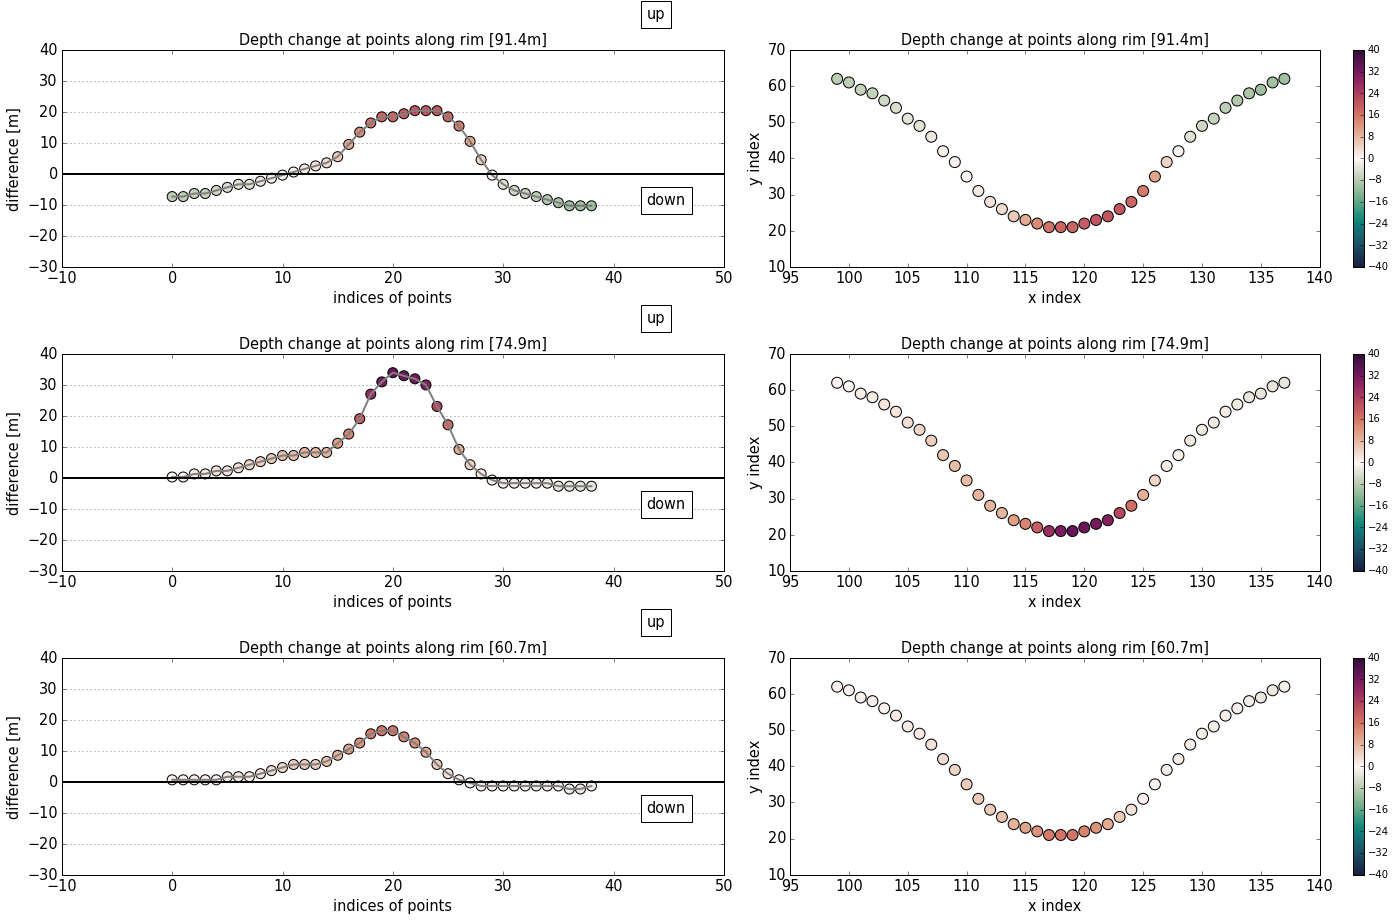

In [9]:
depth_ind_rim = 7
ind_dep_above_rim = depth_ind_rim

fig, ([ax4, ax5], [ax6, ax7], [ax8, ax9]) = plt.subplots(3, 2, figsize = (20,12))
fig.tight_layout(); fig.subplots_adjust(hspace=.4, wspace=.1)

depth_change, d_new = calculate_depth_change(sal_profiles_rim, ind_dep_above_rim)
ax4, ax5 = plot_depth_change(fig, ax4, ax5, depth_change, d_new)

depth_change, d_new = calculate_depth_change(sal_profiles_rim, ind_dep_above_rim-1)
ax6, ax7 = plot_depth_change(fig, ax6, ax7, depth_change, d_new)

depth_change, d_new = calculate_depth_change(sal_profiles_rim, ind_dep_above_rim-2)
ax8, ax9 = plot_depth_change(fig, ax8, ax9, depth_change, d_new)

plt.show

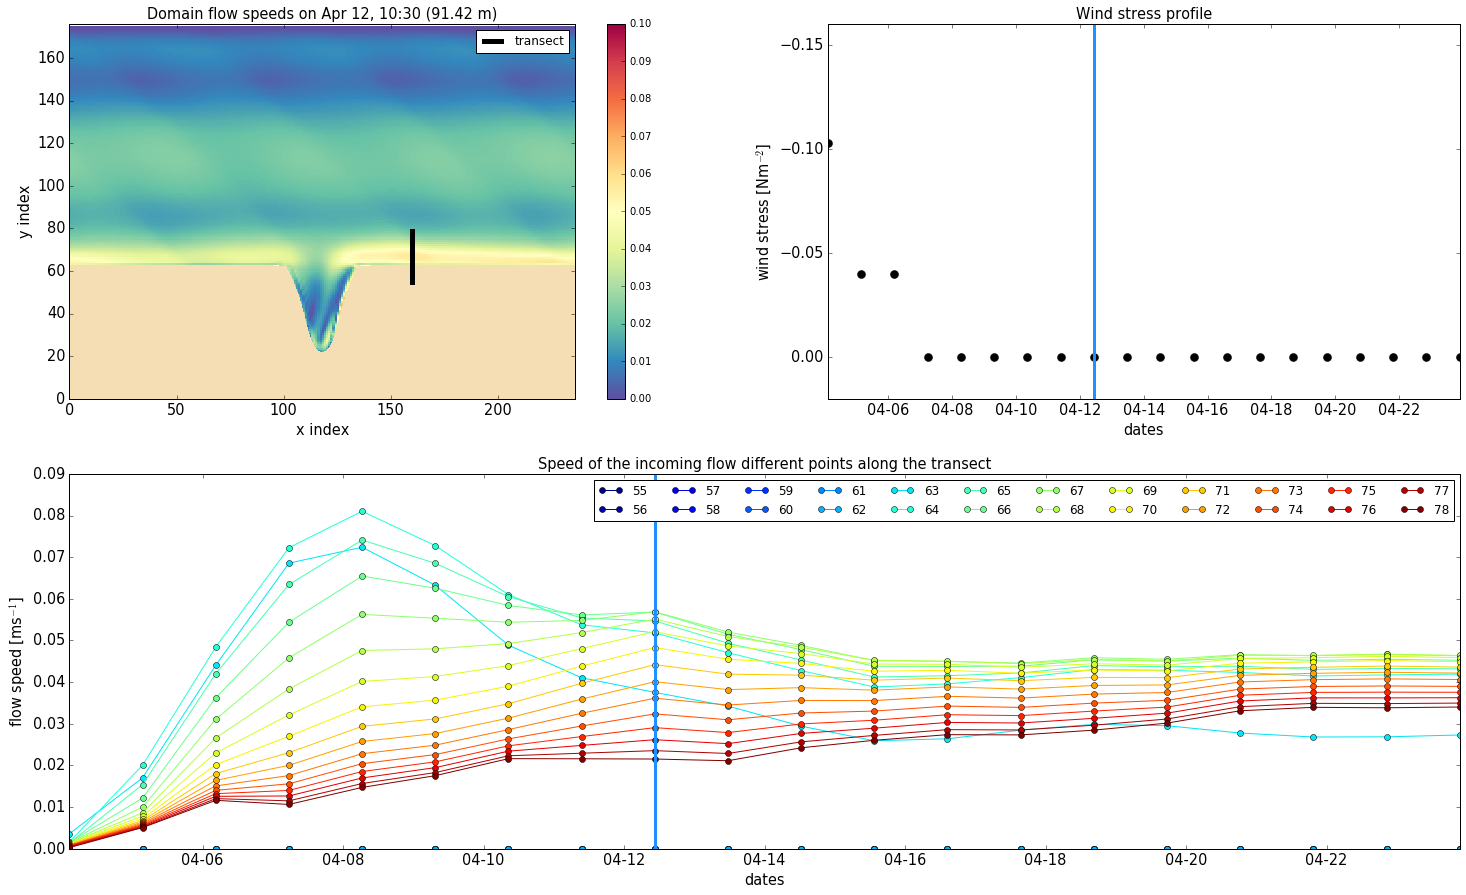

In [16]:
time_shot=202
time_inds = np.arange(2,479,25)
fig = plot_incoming_speeds(U, V, grid, 7, time_inds, time_shot, 0.1, bathy_file, utau)

<function matplotlib.pyplot.show>

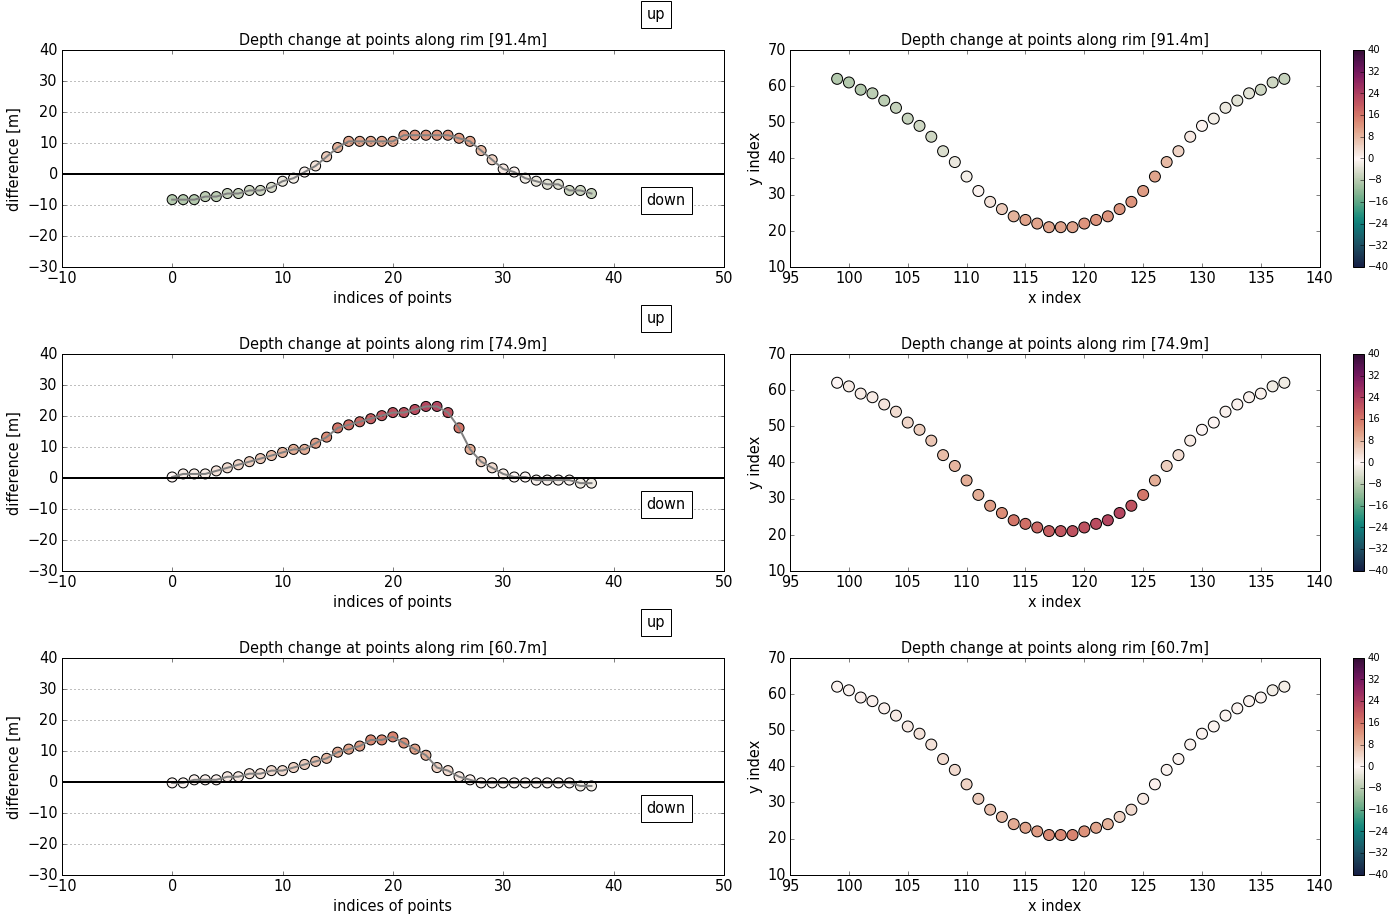

In [10]:
time_shot=202
inds_max_depth = get_inds_max_depth(time_shot)
ys_for_unique_x_values, unique_x_values, x_ind_rim_depth, y_ind_rim_depth = get_unique_values(inds_max_depth)
sal_profiles_rim = get_sal_profiles_rim(ys_for_unique_x_values, unique_x_values)

fig, ([ax4, ax5], [ax6, ax7], [ax8, ax9]) = plt.subplots(3, 2, figsize = (20,12))
fig.tight_layout(); fig.subplots_adjust(hspace=.4, wspace=.1)

depth_change, d_new = calculate_depth_change(sal_profiles_rim, ind_dep_above_rim)
ax4, ax5 = plot_depth_change(fig, ax4, ax5, depth_change, d_new)

depth_change, d_new = calculate_depth_change(sal_profiles_rim, ind_dep_above_rim-1)
ax6, ax7 = plot_depth_change(fig, ax6, ax7, depth_change, d_new)

depth_change, d_new = calculate_depth_change(sal_profiles_rim, ind_dep_above_rim-2)
ax8, ax9 = plot_depth_change(fig, ax8, ax9, depth_change, d_new)

plt.show

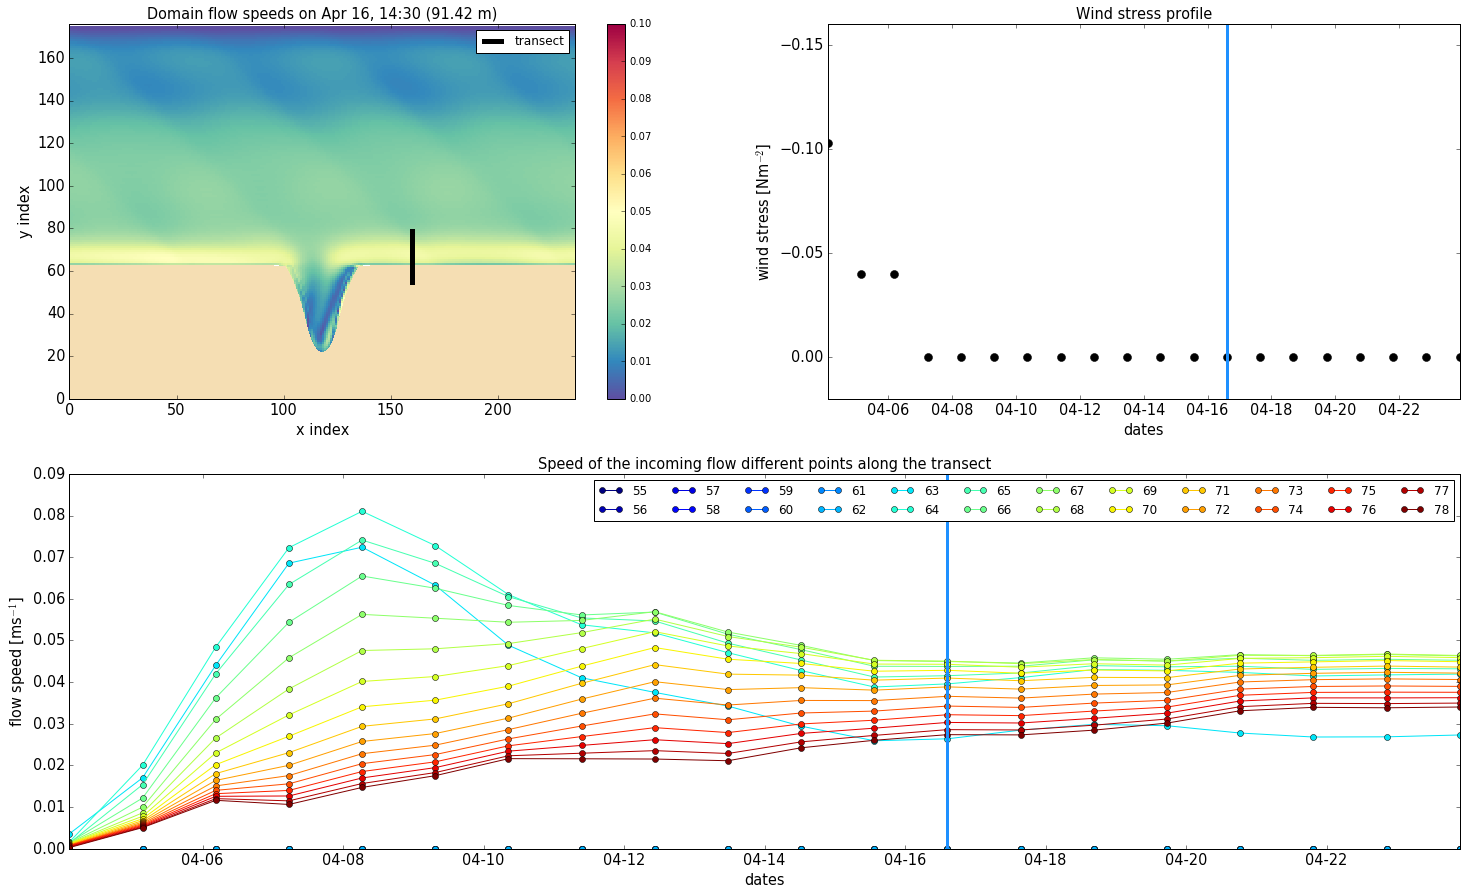

In [18]:
time_shot=302
time_inds = np.arange(2,479,25)
fig = plot_incoming_speeds(U, V, grid, 7, time_inds, time_shot, 0.1, bathy_file, utau)

<function matplotlib.pyplot.show>

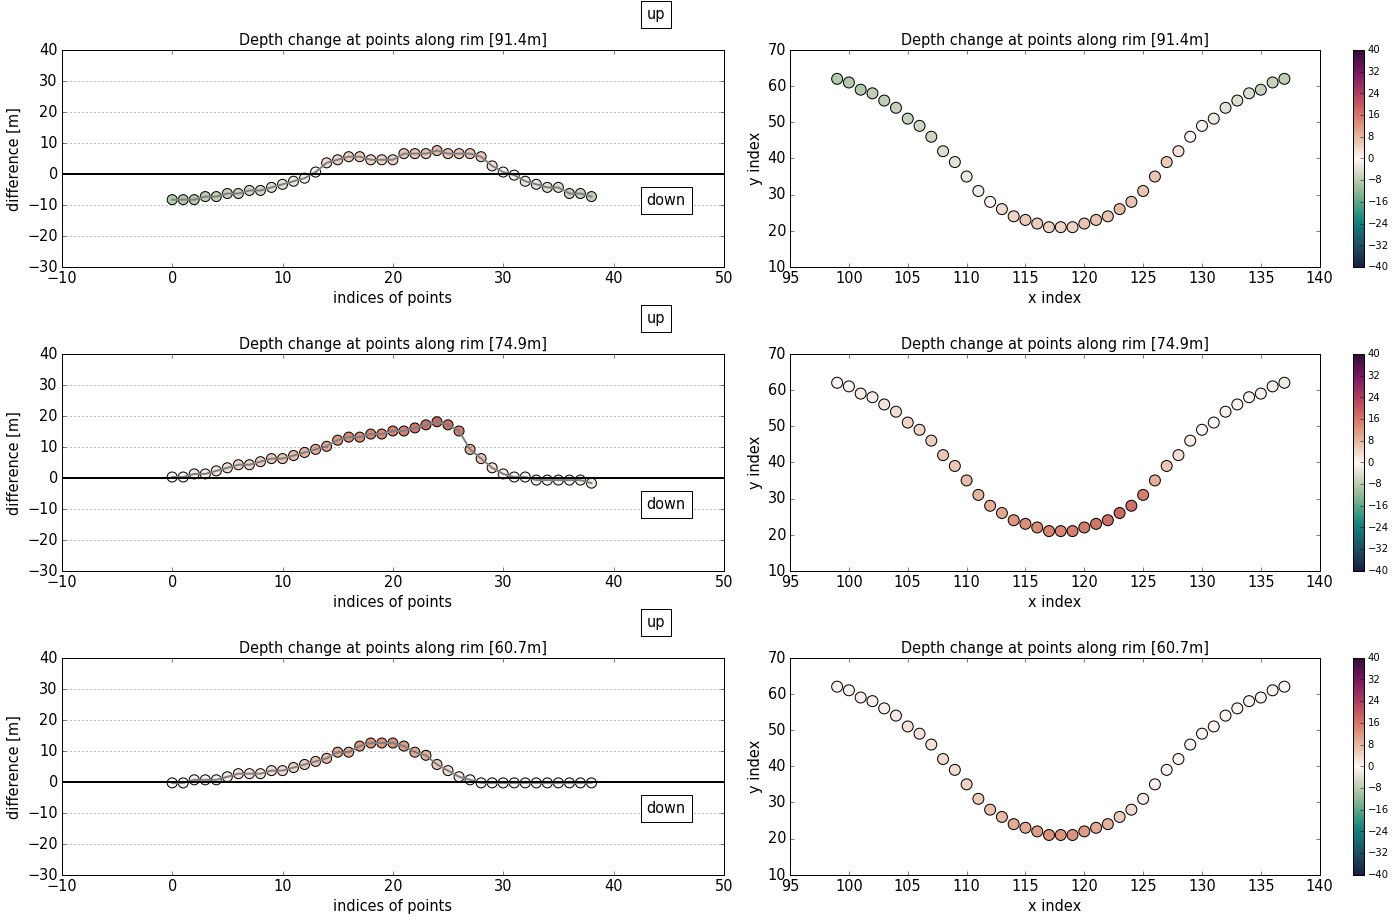

In [11]:
time_shot=302
inds_max_depth = get_inds_max_depth(time_shot)
ys_for_unique_x_values, unique_x_values, x_ind_rim_depth, y_ind_rim_depth = get_unique_values(inds_max_depth)
sal_profiles_rim = get_sal_profiles_rim(ys_for_unique_x_values, unique_x_values)

fig, ([ax4, ax5], [ax6, ax7], [ax8, ax9]) = plt.subplots(3, 2, figsize = (20,12))
fig.tight_layout(); fig.subplots_adjust(hspace=.4, wspace=.1)

depth_change, d_new = calculate_depth_change(sal_profiles_rim, ind_dep_above_rim)
ax4, ax5 = plot_depth_change(fig, ax4, ax5, depth_change, d_new)

depth_change, d_new = calculate_depth_change(sal_profiles_rim, ind_dep_above_rim-1)
ax6, ax7 = plot_depth_change(fig, ax6, ax7, depth_change, d_new)

depth_change, d_new = calculate_depth_change(sal_profiles_rim, ind_dep_above_rim-2)
ax8, ax9 = plot_depth_change(fig, ax8, ax9, depth_change, d_new)

plt.show